# Prueba Modelo con Data Augmentacion:
- Proceso de lectura a través de TF.
- Adicional se vuelve a tomar la parte de la lectura de los CTs una sola vez.

# Modelo.
- Limitación pixeles de -1000 a 0
- Prueba ventana parénquima pulmonar desde W3. Para ver si hay algo raro en el script.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip install volumentations-3D
# !pip install keras-tuner --upgrade
# !pip install keras_applications
# !pip install tensorflow==2.11.0
# !pip install keras==2.11.0
!pip install tensorflow-probability

In [3]:
!pip list | grep tensorflow #tensorflow: 2.14.0, tensorflow-probability: 0.22.0

tensorflow                       2.15.0
tensorflow-datasets              4.9.4
tensorflow-estimator             2.15.0
tensorflow-gcs-config            2.15.0
tensorflow-hub                   0.16.1
tensorflow-io-gcs-filesystem     0.36.0
tensorflow-metadata              1.14.0
tensorflow-probability           0.23.0


In [4]:
# Tratamiento datos
import pandas as pd
import numpy as np
from collections import Counter
import time

# Organizar rutas imágenes
import os
import random

# Lectura tomografías.
import nibabel as nib # Lectura
from scipy import ndimage # Tratamiento

# Modelado
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_probability as tfp
tfd = tfp.distributions

# Data Augmentation
from volumentations import *

# Visualización CTs
import matplotlib.pyplot as plt
import re

import itertools
from functools import partial

pd.set_option('display.max_columns', 500)
pd.set_option('display.float_format', lambda x: f'{x:.3f}')
#pd.set_option('display.float_format', lambda x: f'{x:,.3f}') #add a comma separator between the thousands.
pd.set_option('display.max_colwidth',1000)



np.set_printoptions(threshold=1000, linewidth = 300, edgeitems = 5)
np.set_printoptions(suppress=True)


import pickle

In [5]:
import os
print("Ruta: ",os.getcwd())
print("Directorios: ",os.listdir())
os.chdir(r'/content/gdrive/MyDrive/Maestria/Tesis/Bayesian_NN/Code/tf_mnf/tf-mnf')
print("Ruta: ",os.getcwd())

Ruta:  /content
Directorios:  ['.config', 'gdrive', 'sample_data']
Ruta:  /content/gdrive/MyDrive/Maestria/Tesis/Bayesian_NN/Code/tf_mnf/tf-mnf


In [6]:
from tf_mnf.layers import MNFDense, MNFConv2D
# from tf_mnf.layers import MNFConv2D, MNFDense,MNFConv3D

In [7]:
os.chdir(r'/content')
print("Ruta: ",os.getcwd())
print("Directorios: ",os.listdir())

Ruta:  /content
Directorios:  ['.config', 'gdrive', 'sample_data']


# Parámetros

In [8]:
ambiente = 'GOOGLE' # 'GOOGLE' o 'LOCAL'
reduccion = "MEAN" # SUM o MEAN
reading_cts_tf = False
version_modelo = "MNF_Arch_W4_V1_Optimizado_2D_MEAN" # CAMBIAR!!!!!!!!!!!!!!!!!!!!!!!!!!

# Ventana Parénquima Pulmonar
min_ventana = -1000
max_ventana = 0

# Rutas Datasets
ruta_dfs_google = r'/content/gdrive/MyDrive/Maestria/Tesis/Bayesian_NN/Data/Path_Sets/'
ruta_dfs_local = r'G:/Mi unidad/Maestria/Tesis/Bayesian_NN/Data/Path_Sets/'

ruta_modelo_google = r'/content/gdrive/MyDrive/Maestria/Tesis/Bayesian_NN/Modelos_Colab/'
ruta_modelo_local = r'G:/Mi unidad/Maestria/Tesis/Bayesian_NN/Modelos/'

# Rutas
if ambiente == 'GOOGLE':
    print("Rutas DFs")
    ruta_dfs = ruta_dfs_google

    print("El modelo se guardará en Modelos_Colab")
    ruta_modelo = ruta_modelo_google
    file_modelo = r'{}Modelo_{}'.format(ruta_modelo_google,version_modelo)
    file_history = r'{}/History_Modelo_{}'.format(file_modelo,version_modelo)

else:
    print("Rutas DFs")
    ruta_dfs = ruta_dfs_local

    print("El modelo se guardará en Modelos")
    ruta_modelo = ruta_modelo_local
    file_modelo = r'{}Modelo_{}'.format(ruta_modelo_local,version_modelo)
    file_history = r'{}/History_Modelo_{}'.format(file_modelo,version_modelo)

# Validando rutas
if os.path.exists(ruta_modelo):
    print("Existe ruta guardado modelo.")
    print(f"El modelo se guardará en: {file_modelo}")
else:
    print("Creando ruta para modelos!!!!!!! ")
    os.makedirs(ruta_modelo)

print(ruta_modelo)

# Parámetros Redes:
BATCH_SIZE=2
RANDOM = 9411
initial_learning_rate = 0.0001
epochs = 300

Rutas DFs
El modelo se guardará en Modelos_Colab
Existe ruta guardado modelo.
El modelo se guardará en: /content/gdrive/MyDrive/Maestria/Tesis/Bayesian_NN/Modelos_Colab/Modelo_MNF_Arch_W4_V1_Optimizado_2D_MEAN
/content/gdrive/MyDrive/Maestria/Tesis/Bayesian_NN/Modelos_Colab/


# Lectura Imágenes

## Rutas

In [9]:
if ambiente == 'GOOGLE':
    print("Leyendo rutas de google")
    train_df = pd.read_csv(ruta_dfs + 'train_df.csv')
    test_df = pd.read_csv(ruta_dfs + 'test_df.csv')
    valid_df = pd.read_csv(ruta_dfs + 'valid_df.csv')

    train_df['path'] = train_df['File_Path_Google']
    test_df['path'] = test_df['File_Path_Google']
    valid_df['path'] = valid_df['File_Path_Google']

else:
    print("Leyendo rutas del local")
    train_df = pd.read_csv(ruta_dfs + 'train_df.csv')
    test_df = pd.read_csv(ruta_dfs + 'test_df.csv')
    valid_df = pd.read_csv(ruta_dfs + 'valid_df.csv')

    train_df['path'] = train_df['File_Path']
    test_df['path'] = test_df['File_Path']
    valid_df['path'] = valid_df['File_Path']


Leyendo rutas de google


In [10]:
# train_df = pd.DataFrame({'path' : ['/content/data/study_0001.nii.gz',
#                                    '/content/data/study_0002.nii.gz',
#                                    '/content/data/study_0003.nii.gz',
#                                    '/content/data/study_0004.nii.gz']})
# train_df['Label'] = 0

# valid_df = pd.DataFrame({'path' : ['/content/data/study_0003.nii.gz',
#                                    '/content/data/study_0004.nii.gz',
#                                    '/content/data/study_0005.nii.gz']})
# valid_df['Label'] = 0

# test_df = valid_df.copy()


# train_df

In [11]:
valid_df.head()

,File_Path,File_Path_Google,Label,path
0,G:/Mi unidad/Maestria/Tesis/Bayesian_NN/Data/Real/CT-0/study_0026.nii.gz,/content/gdrive/MyDrive/Maestria/Tesis/Bayesian_NN/Data/Real/CT-0/study_0026.nii.gz,0,/content/gdrive/MyDrive/Maestria/Tesis/Bayesian_NN/Data/Real/CT-0/study_0026.nii.gz
1,G:/Mi unidad/Maestria/Tesis/Bayesian_NN/Data/Real/CT-0/study_0031.nii.gz,/content/gdrive/MyDrive/Maestria/Tesis/Bayesian_NN/Data/Real/CT-0/study_0031.nii.gz,0,/content/gdrive/MyDrive/Maestria/Tesis/Bayesian_NN/Data/Real/CT-0/study_0031.nii.gz
2,G:/Mi unidad/Maestria/Tesis/Bayesian_NN/Data/Real/CT-0/study_0180.nii.gz,/content/gdrive/MyDrive/Maestria/Tesis/Bayesian_NN/Data/Real/CT-0/study_0180.nii.gz,0,/content/gdrive/MyDrive/Maestria/Tesis/Bayesian_NN/Data/Real/CT-0/study_0180.nii.gz
3,G:/Mi unidad/Maestria/Tesis/Bayesian_NN/Data/Real/CT-0/study_0075.nii.gz,/content/gdrive/MyDrive/Maestria/Tesis/Bayesian_NN/Data/Real/CT-0/study_0075.nii.gz,0,/content/gdrive/MyDrive/Maestria/Tesis/Bayesian_NN/Data/Real/CT-0/study_0075.nii.gz
4,G:/Mi unidad/Maestria/Tesis/Bayesian_NN/Data/Real/CT-0/study_0139.nii.gz,/content/gdrive/MyDrive/Maestria/Tesis/Bayesian_NN/Data/Real/CT-0/study_0139.nii.gz,0,/content/gdrive/MyDrive/Maestria/Tesis/Bayesian_NN/Data/Real/CT-0/study_0139.nii.gz


## Lectura:

In [12]:
def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata(caching='unchanged')
    return scan


def normalize(volume, min_normalize, max_normalize):
  """Normalize the volume"""
  min = min_normalize #-1000
  max = max_normalize #400
  volume[volume < min] = min
  volume[volume > max] = max
  volume = (volume - min) / (max - min)
  volume = volume.astype("float32")
  return volume


def resize_volume(img):
  # Esta conversión de 3D a 2D se puede hacer antes o después del zoom.
  if reduccion == 'SUM':
    # Sumamos la 3ra dimensión.
    img = np.sum(img,axis=-1)
  if reduccion == 'MEAN':
    # Promediamos la 3ra dimensión.
    img = np.mean(img,axis=-1)
  if reduccion == 'MAX':
    # Promediamos la 3ra dimensión.
    img = np.max(img,axis=-1)

  """Resize across z-axis"""
  # Set the desired depth
  desired_width = 128
  desired_height = 128
  # Get current depth
  current_width = img.shape[0]
  current_height = img.shape[1]
  # Compute depth factor
  width = current_width / desired_width
  height = current_height / desired_height
  width_factor = 1 / width
  height_factor = 1 / height

  # Resize across z-axis
  tic = time.time()
  img = ndimage.zoom(img, (width_factor, height_factor), order=1)
  #print("     Tiempo zoom:",time.time() - tic)

  # Rotate
  tic = time.time()
  img = ndimage.rotate(img, 90, reshape=False)
  #print("     Tiempo rotate:",time.time() - tic)

  return img

In [13]:
def rotate(volume):
    # define some rotation angles
    angles = [-20, -10, -5, 5, 10, 20]
    # pick angles at random
    angle = random.choice(angles)
    # rotate volume
    volume = ndimage.rotate(volume, angle, reshape=False)
    volume[volume < 0] = 0
    volume[volume > 1] = 1
    return volume

In [14]:
def get_augmentation(patch_size):
    return Compose([
        #Resize(patch_size, interpolation=1, resize_type=0, always_apply=True, p=1.0),
        Flip(0, p=1), # Eje X
        Flip(1, p=1), # Eje Y
        Flip(2, p=1), # Eje Z
        GaussianNoise(var_limit=(0.0001, 0.0005), p=1),
        ColorJitter(brightness=(1,3),contrast=(0.4,0.8),saturation=0,hue=0, p=1),
    ], p=1)

def augmentor(img):
    aug = get_augmentation((128,128,64))
    data = {'image': img}
    aug_data = aug(**data)
    img = aug_data['image']
    return np.ndarray.astype(img , np.float32)



In [15]:
def load_arrays(path, training_):

    #print(path.numpy().decode())
    tic1 = time.time()

    # Lectura CT
    tic = time.time()
    image_ = nib.load(path.numpy().decode())
    #print("Tiempo lectura:",time.time() - tic)

    # Convertirlo en array
    tic = time.time()
    image_ = image_.get_fdata()
    #print("shape:",image_.shape)
    #print("Tiempo array:",time.time() - tic)

    # Aplicar función de estandarización número de cortes y rotación 90 grados
    tic = time.time()
    image = resize_volume(image_)[..., None]
    #print("Tiempo resize:",time.time() - tic)

    # Aplicar función normalización
    tic = time.time()
    image = normalize(image, min_normalize=min_ventana, max_normalize=max_ventana)
    #print("Tiempo normalizacion:",time.time() - tic)

    if training_:
        #print("Aplicando Data Augmentation************************************")

        # Aplicar rotación aleatoria
        tic = time.time()
        image = rotate(image)
        #print("Tiempo rotación aleatoria:",time.time() - tic)

        # Implementar data augmentation
        tic = time.time()
        #image = augmentor(image)
        #print("Tiempo aug:",time.time() - tic)

        # Limitando valores entre 0-1
        tic = time.time()
        #image = tf.clip_by_value(image, clip_value_min = 0, clip_value_max = 1)
        #print("Tiempo clip_by_value:",time.time() - tic)

    else:
        #print("Las tomografías se cargan solo con el resize y la normalización")

        #print("|| Tiempo total lectura tomografía: ", time.time() - tic1)
        #print("---")

        image = image


    return image#.reshape(image_.shape+(1,))

def tf_data_array(filenames1, labels, training_):
    [image,] = tf.py_function(func= load_arrays,  inp=[filenames1, training_], Tout=[tf.float32])
    image.set_shape((128,128,1))
    return image,  labels

In [16]:
def datasets_iteration(dataset_row, training=False):
    filename = dataset_row['path']
    labels = dataset_row['Label']
    dataset = tf.data.Dataset.from_tensor_slices((filename,labels))

    #print(dataset)

    if training:
        dataset = dataset.shuffle(len(dataset_row),seed=RANDOM)

    #Aplicamos todas las funciones de pre-procesamiento
    #dataset = dataset.map(tf_data_array).batch(BATCH_SIZE)#.prefetch(tf.data.AUTOTUNE)
    # dataset = dataset.map(tf_data_array).cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    # dataset = dataset.map(tf_data_array, num_parallel_calls = 4).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
    # dataset = dataset.map(tf_data_array, num_parallel_calls = 4).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    # dataset = dataset.map(tf_data_array, num_parallel_calls = 4).batch(BATCH_SIZE).prefetch(1)
    dataset = dataset.map(partial(tf_data_array, training_ = training), num_parallel_calls = tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(2)

    # https://stackoverflow.com/questions/59228816/what-do-the-tensorflow-datasets-functions-cache-and-prefetch-do
    # https://stackoverflow.com/questions/63796936/what-is-the-proper-use-of-tensorflow-dataset-prefetch-and-cache-options
    # https://cs230.stanford.edu/blog/datapipeline/#best-practices
    return dataset

In [17]:
train_dataset = datasets_iteration(train_df,True)
test_dataset = datasets_iteration(test_df)
validation_dataset = datasets_iteration(valid_df)

# train_dataset = datasets_iteration(train_df.iloc[[5,6,7,8,9,290,291,292,293,294]],True)
# test_dataset = datasets_iteration(test_df.iloc[[5,6,7,8,9,79,80,81,82,83]])
# validation_dataset = datasets_iteration(valid_df.iloc[[5,6,7,8,9,40,41,42,43,44]])

In [18]:
validation_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

### Método una sola lectura

In [19]:
def process_scan(path, min_normalize, max_normalize):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    # Resize width, height and depth
    volume = resize_volume(volume)[..., None]
    # Normalize
    volume = normalize(volume, min_normalize=min_normalize, max_normalize=max_normalize)

    return volume

def data_augmentation(volume, training_):

    if training_:

        #print("Aplicando Data Augmentation************************************")

        # Aplicar rotación aleatoria
        tic = time.time()
        volume = rotate(volume)
        #print("Tiempo rotación aleatoria:",time.time() - tic)

        # Implementar data augmentation
        tic = time.time()
        # volume = augmentor(volume)
        #print("Tiempo aug:",time.time() - tic)

        # Limitando valores entre 0-1
        tic = time.time()
        # volume = tf.clip_by_value(volume, clip_value_min = 0, clip_value_max = 1)
        #print("Tiempo clip_by_value:",time.time() - tic)

    else:
        volume = volume

    return volume


def tf_data_array2(images, labels, training_):
    [image,] = tf.py_function(func= data_augmentation,  inp=[images, training_], Tout=[tf.float32])
    image.set_shape((128,128,1))
    return image,  labels



In [20]:
if reading_cts_tf == False:
  print("Leyendo CTs una sola vez")
  # Leyendo tomografías de entrenamiento
  print("Leyendo tomografías de entrenamiento")
  tic = time.time()
  x_train = np.array([process_scan(path, min_normalize= min_ventana, max_normalize=max_ventana) for path in train_df['path']])
  print("--- %s minutos ---" % ((time.time() - tic)/60))

  print("Leyendo tomografías de test")
  tic = time.time()
  x_test = np.array([process_scan(path, min_normalize= min_ventana, max_normalize=max_ventana) for path in test_df['path']])
  print("--- %s minutos ---" % ((time.time() - tic)/60))

  print("Leyendo tomografías de validación")
  tic = time.time()
  x_valid = np.array([process_scan(path, min_normalize= min_ventana, max_normalize=max_ventana) for path in valid_df['path']])
  print("--- %s minutos ---" % ((time.time() - tic)/60))


Leyendo CTs una sola vez
Leyendo tomografías de entrenamiento
--- 7.942556854089101 minutos ---
Leyendo tomografías de test
--- 2.152067418893178 minutos ---
Leyendo tomografías de validación
--- 1.1147190610567728 minutos ---


In [21]:
# Validación Dimensión Arrays:
print(f"Dim x_train: {x_train.shape} -- Dim y_train: {len(train_df['path'])}. -- {Counter(train_df['Label'])}")
print(f"Dim x_train: {x_test.shape} -- Dim y_train: {len(test_df['path'])}. -- {Counter(test_df['Label'])}")
print(f"Dim x_train: {x_valid.shape} -- Dim y_train: {len(valid_df['path'])}. -- {Counter(valid_df['Label'])}")

Dim x_train: (295, 128, 128, 1) -- Dim y_train: 295. -- Counter({0: 177, 1: 118})
Dim x_train: (84, 128, 128, 1) -- Dim y_train: 84. -- Counter({0: 50, 1: 34})
Dim x_train: (45, 128, 128, 1) -- Dim y_train: 45. -- Counter({0: 27, 1: 18})


In [22]:
def datasets_iteration2(images, dataset_row, training=False):

    labels = dataset_row['Label']

    dataset = tf.data.Dataset.from_tensor_slices((images,labels))

    if training:
        dataset = dataset.shuffle(len(images),seed=RANDOM)

    dataset = dataset.map(partial(tf_data_array2, training_ = training), num_parallel_calls = tf.data.AUTOTUNE).batch(BATCH_SIZE)#.prefetch(1)

    #dataset = dataset.batch(BATCH_SIZE).prefetch(2)

    return dataset


In [23]:
if reading_cts_tf == False:
  print("Datasets creados con datasets_iteration2 ************")
  train_dataset = datasets_iteration2(x_train, train_df,True)
  test_dataset = datasets_iteration2(x_test, test_df)
  validation_dataset = datasets_iteration2(x_valid, valid_df)
else:
  print("Se mantiene el objeto TF para lectura de CTs según el batch")

Datasets creados con datasets_iteration2 ************


In [24]:
validation_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

## Visualizamos algunas imágenes

### Train

In [25]:
tic = time.time()
data = train_dataset.take(1) # Tomamos primer batch
data2 = list(data)

images, labels = data2[0]
images = images.numpy()
print("******* Tiempo total lectura batch: ", time.time() - tic)


******* Tiempo total lectura batch:  0.05234193801879883


CT Etiqueta: 1 
G:/Mi unidad/Maestria/Tesis/Bayesian_NN/Data/Imgs/TF_VF_Index0_Rango-1000_0.png


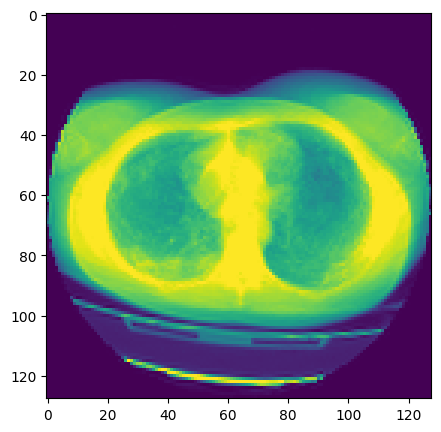

In [26]:
index_ct = 0
mensaje = f"CT Etiqueta: {labels.numpy()[index_ct]} "
print(mensaje)
img_print = images[index_ct]
label_print = labels.numpy()[index_ct]
fig = plt.figure(figsize=(10, 5))
columns = 10
rows = 7
depth_img = img_print.shape[2]

file_image_path = f'G:/Mi unidad/Maestria/Tesis/Bayesian_NN/Data/Imgs/TF_VF_Index{index_ct}_Rango{min_ventana}_{max_ventana}.png'
print(file_image_path)

plt.imshow(img_print)

# # ax enables access to manipulate each of subplots
# ax = []

# for i in range(1, depth_img+1):
#     img = np.squeeze(img_print[:, :, i-1])
#     #fig.add_subplot(rows, columns, i)
#     ax.append( fig.add_subplot(rows, columns, i))
#     ax[-1].set_title("depth:"+str(i))  # set title
#     plt.imshow(img, cmap='gray')
# plt.suptitle(mensaje)
# #plt.savefig(file_image_path)
# plt.show()

### Valid

In [27]:
tic = time.time()
data = validation_dataset.take(1) # Tomamos primer batch
data2 = list(data)

images, labels = data2[0]
images = images.numpy()
print("******* Tiempo total lectura batch: ", time.time() - tic)


******* Tiempo total lectura batch:  0.01759481430053711


CT Etiqueta: 0 
G:/Mi unidad/Maestria/Tesis/Bayesian_NN/Data/Imgs/TF_VF_Index0_Rango-1000_0.png


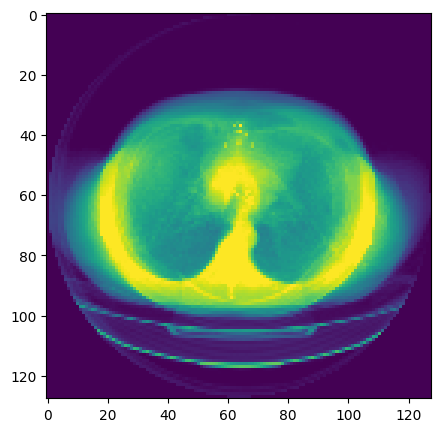

In [28]:
index_ct = 0
mensaje = f"CT Etiqueta: {labels.numpy()[index_ct]} "
print(mensaje)
img_print = images[index_ct]
label_print = labels.numpy()[index_ct]
fig = plt.figure(figsize=(10, 5))
columns = 10
rows = 7
depth_img = img_print.shape[2]

file_image_path = f'G:/Mi unidad/Maestria/Tesis/Bayesian_NN/Data/Imgs/TF_VF_Index{index_ct}_Rango{min_ventana}_{max_ventana}.png'
print(file_image_path)

plt.imshow(img_print)

# # ax enables access to manipulate each of subplots
# ax = []

# for i in range(1, depth_img+1):
#     img = np.squeeze(img_print[:, :, i-1])
#     #fig.add_subplot(rows, columns, i)
#     ax.append( fig.add_subplot(rows, columns, i))
#     ax[-1].set_title("depth:"+str(i))  # set title
#     plt.imshow(img, cmap='gray')
# plt.suptitle(mensaje)
# #plt.savefig(file_image_path)
# plt.show()

# Modelo 1 - Data Augmentation Keras

In [29]:
def get_model(width=128, height=128):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, 1))

    x = MNFConv2D(n_filters=128, kernel_size=3)(inputs)
    x = layers.Activation("relu")(x)
    x = layers.MaxPool2D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = MNFConv2D(n_filters=128, kernel_size=3)(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPool2D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = MNFConv2D(n_filters=256, kernel_size=3)(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPool2D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = MNFConv2D(n_filters=512, kernel_size=3)(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPool2D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalMaxPooling2D()(x)
    x = layers.Dense(units=256, activation="relu")(x)
    x = layers.Dropout(0.2)(x)

    # Opción 1 - A
    # x = layers.Dense(units=tfp.layers.IndependentBernoulli.params_size(1))(x)
    # outputs = tfp.layers.IndependentBernoulli(1)(x)

    # Opción 1 - B
    # x = layers.Dense(units=tfp.layers.IndependentBernoulli.params_size(1))(x)
    # outputs = tfp.layers.IndependentBernoulli(1, tfd.Bernoulli.mean)(x)

    # Opcion 2 - A
    # x = MNFDense(tfp.layers.IndependentBernoulli.params_size(1))(x)
    # outputs = tfp.layers.IndependentBernoulli(1)(x) # tfd.Bernoulli.mean

    # Opcion 2 - B
    x = MNFDense(tfp.layers.IndependentBernoulli.params_size(1), name = "last_mnf_dense")(x)
    outputs = tfp.layers.IndependentBernoulli(1, tfd.Bernoulli.mean)(x) # tfd.Bernoulli.mean

    # Define the model.
    model = keras.Model(inputs, outputs, name="2dcnn")
    return model


# Build model.
model = get_model(width=128, height=128)
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Model: "2dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 mnf_conv2d (MNFConv2D)      (None, 126, 126, 128)     42222     
                                                                 
 activation (Activation)     (None, 126, 126, 128)     0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 128)       0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 63, 63, 128)       512       
 Normalization)                                                  
                                                                 
 mnf_conv2d_1 (MNFConv2D)    (None, 61, 61, 128)       335973

In [30]:
for layer in model.layers:
    print(layer.name)

input_1
mnf_conv2d
activation
max_pooling2d
batch_normalization
mnf_conv2d_1
activation_1
max_pooling2d_1
batch_normalization_1
mnf_conv2d_2
activation_2
max_pooling2d_2
batch_normalization_2
mnf_conv2d_3
activation_3
max_pooling2d_3
batch_normalization_3
global_max_pooling2d
dense
dropout
last_mnf_dense
independent_bernoulli


In [31]:
[lyr for lyr in model.layers if hasattr(lyr, "kl_div")]

In [32]:
# Revisar grabación 2024-02-12 17-03-01 minuto: 51:33 (Para ver pantallazo. Ambas valores de la función de pérdida son similares, bajo la forma del Profe vs la propuesta)
def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

def compute_kl_div(model):
    """Compute current KL divergence of the whole model.
    Can be used as a regularization term during training.
    """
    return sum(lyr.kl_div() for lyr in model.layers if hasattr(lyr, "kl_div"))

len_train = len(train_dataset) # Originalmente se había ejecutado con len(train_df['path'])
print(len_train)
def kl_loss_v2(y_true, y_predict):
  nll_ = nll(y_true, y_predict)
  kl_loss = compute_kl_div(model) / len_train
  return kl_loss + nll_

148


In [33]:
# def nll(y_true, y_pred):
#     return -y_pred.log_prob(y_true)

# len_train = len(train_dataset) # Originalmente se había ejecutado con len(train_df['path'])
# print(len_train)
# def kl_loss(y_true, y_predict):
#   nll_ = nll(y_true, y_predict)
#   kl_mnf = tf.math.reduce_sum(model.layers[1].kl_div() + model.layers[-2].kl_div())
#   kl = kl_mnf / len_train
#   return kl + nll_

In [34]:
os.getcwd()

'/content'

In [35]:
if os.path.isfile(file_modelo):
  print(f"Ruta modelo existe!!!!!!!!!!!!!!!!!!!!!!!!!!!! {file_modelo}")
else:
  print(f"Se creará archivo: {file_modelo}")

Se creará archivo: /content/gdrive/MyDrive/Maestria/Tesis/Bayesian_NN/Modelos_Colab/Modelo_MNF_Arch_W4_V1_Optimizado_2D_MEAN


## Compilar Modelo

In [36]:
tic = time.time()
# Compile model.
# initial_learning_rate = 0.0001
# lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
# )

# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min' ,factor=0.8,verbose=1,
#                               patience=5, min_lr=1e-6)

# model.compile(
#     loss="binary_crossentropy",
#     optimizer=keras.optimizers.Adam(learning_rate=initial_learning_rate),
#     metrics=["acc"],
# )

model.compile(
    loss= kl_loss_v2, # Si es opción 2: kl_loss
    optimizer=keras.optimizers.Adam(learning_rate=initial_learning_rate),
    metrics=["acc", "BinaryIoU", "Recall"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    file_modelo,
    save_best_only=True, monitor = "val_loss", mode = "min", save_weights_only = False, verbose = 1,
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_loss", mode = 'min', restore_best_weights = True, patience=15, verbose = 1)

# Train the model, doing validation at the end of each epoch
# epochs = 100
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    verbose=1,
    callbacks=[checkpoint_cb], #early_stopping_cb], #reduce_lr],
)
print("******* Tiempo total entrenamiento en minutos: ", (time.time() - tic)/60)

Epoch 1/300
148/148 [==============================] - ETA: 0s - loss: 43914.3516 - acc: 0.5763 - binary_io_u: 0.3177 - recall: 0.0847
Epoch 1: val_loss improved from inf to 43859.92188, saving model to /content/gdrive/MyDrive/Maestria/Tesis/Bayesian_NN/Modelos_Colab/Modelo_MNF_Arch_W4_V1_Optimizado_2D_MEAN
148/148 [==============================] - 52s 156ms/step - loss: 43914.3516 - acc: 0.5763 - binary_io_u: 0.3177 - recall: 0.0847 - val_loss: 43859.9219 - val_acc: 0.5111 - val_binary_io_u: 0.3312 - val_recall: 0.3889
Epoch 2/300
147/148 [============================>.] - ETA: 0s - loss: 43814.4336 - acc: 0.5850 - binary_io_u: 0.3258 - recall: 0.0932
Epoch 2: val_loss improved from 43859.92188 to 43770.49219, saving model to /content/gdrive/MyDrive/Maestria/Tesis/Bayesian_NN/Modelos_Colab/Modelo_MNF_Arch_W4_V1_Optimizado_2D_MEAN
148/148 [==============================] - 18s 122ms/step - loss: 43814.2852 - acc: 0.5864 - binary_io_u: 0.3266 - recall: 0.0932 - val_loss: 43770.4922 - v

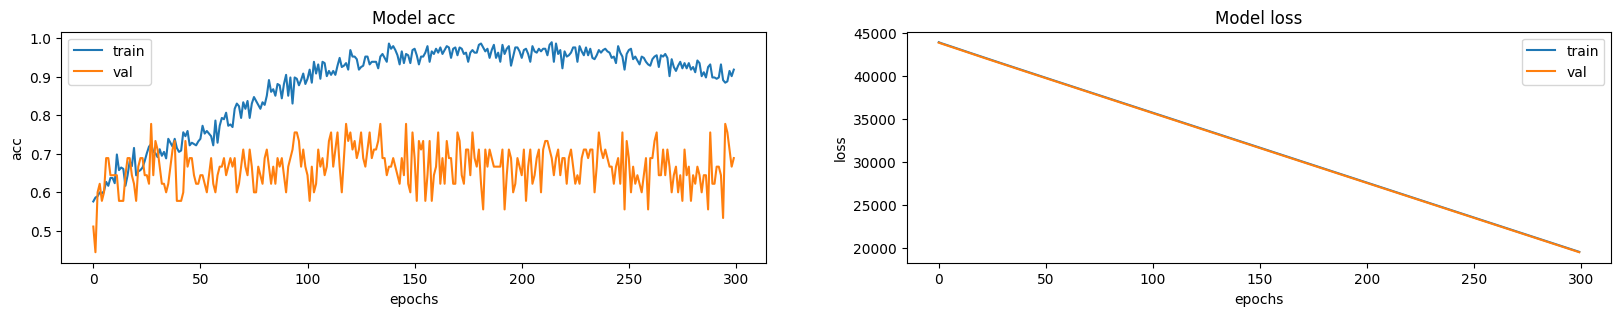

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

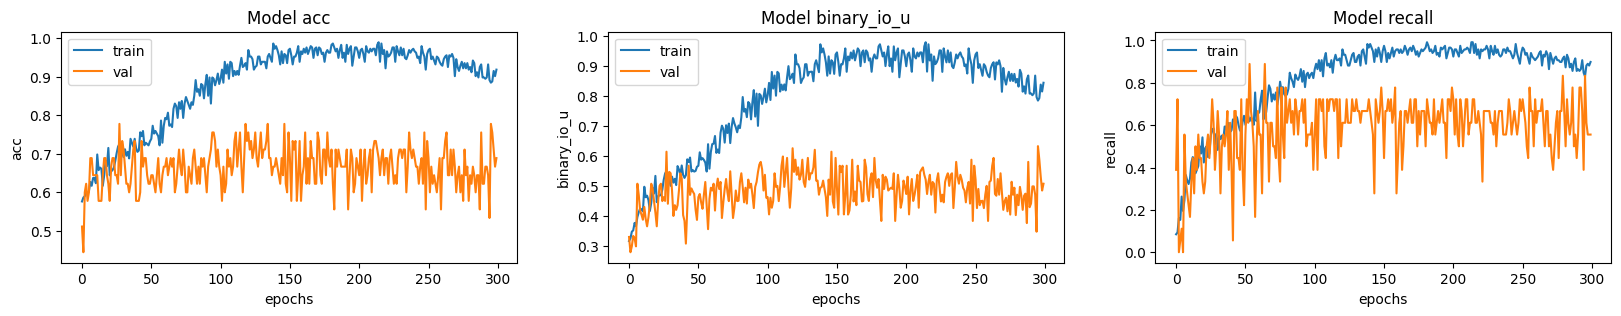

In [38]:
fig, ax = plt.subplots(1, 3, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc","binary_io_u", "recall"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [39]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'acc', 'binary_io_u', 'recall', 'val_loss', 'val_acc', 'val_binary_io_u', 'val_recall'])


In [40]:
file_history

'/content/gdrive/MyDrive/Maestria/Tesis/Bayesian_NN/Modelos_Colab/Modelo_MNF_Arch_W4_V1_Optimizado_2D_MEAN/History_Modelo_MNF_Arch_W4_V1_Optimizado_2D_MEAN'

In [41]:
# # Save the weights
# model.save_weights(file_modelo, overwrite=True)

In [42]:
with open(file_history, 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

# Para leer https://stackoverflow.com/questions/41061457/keras-how-to-save-the-training-history-attribute-of-the-history-object

In [43]:
model.evaluate(validation_dataset, verbose=2)

23/23 - 0s - loss: 19460.5059 - acc: 0.7111 - binary_io_u: 0.5380 - recall: 0.6111 - 331ms/epoch - 14ms/step


[19460.505859375, 0.7111111283302307, 0.5379902124404907, 0.6111111044883728]

In [44]:
# file_modelo2 = '/content/gdrive/MyDrive/Maestria/Tesis/Bayesian_NN/Modelos_Colab/Modelo_Keras_Arch_3D_W4_V1.h5'
print(f"Leyendo pesos del modelo: {file_modelo}")
model.load_weights(file_modelo)

Leyendo pesos del modelo: /content/gdrive/MyDrive/Maestria/Tesis/Bayesian_NN/Modelos_Colab/Modelo_MNF_Arch_W4_V1_Optimizado_2D_MEAN


In [45]:
model.evaluate(validation_dataset, verbose=2)

23/23 - 0s - loss: 19460.3672 - acc: 0.6889 - binary_io_u: 0.5186 - recall: 0.6667 - 291ms/epoch - 13ms/step


[19460.3671875, 0.6888889074325562, 0.5186480283737183, 0.6666666865348816]

In [46]:
y_valid_estimado = model.predict(validation_dataset)

23/23 [==============================] - 1s 6ms/step


In [47]:
y_valid_estimado

array([[0.32259053],
       [0.00194198],
       [0.01946748],
       [0.03412358],
       [0.5490589 ],
       [0.8808112 ],
       [0.00375034],
       [0.15164681],
       [0.15395936],
       [0.00006718],
       [0.01722755],
       [0.280741  ],
       [0.983913  ],
       [0.568432  ],
       [0.31510362],
       [0.38466457],
       [0.00172037],
       [0.8876309 ],
       [0.09357094],
       [0.00089356],
       [0.1534163 ],
       [0.37820745],
       [0.00330236],
       [0.02453769],
       [0.9411147 ],
       [0.00017799],
       [0.01245845],
       [0.97803336],
       [0.99308807],
       [0.2993969 ],
       [0.9855305 ],
       [0.00069257],
       [0.02873531],
       [0.0003639 ],
       [0.81731457],
       [0.99833953],
       [0.99862885],
       [0.42536724],
       [0.11134747],
       [0.4695504 ],
       [0.6474341 ],
       [0.8834293 ],
       [0.7115661 ],
       [0.9723226 ],
       [0.10847186]], dtype=float32)

## Calculando métricas del modelo

In [48]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(
    cm, classes,
    normalize = False,
    title = 'Matriz de Confusión',
    cmap = plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalizacion can be applied by setting 'normalize = True'
    """

    plt.imshow(cm,interpolation = 'nearest', cmap= cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation = 45)
    plt.yticks(tick_marks,classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel("Etiqueta Verdadera")
    plt.xlabel("Etiqueta Predicha")

def calcular_metricas(nombre_modelo, tipo_set, etiquetas_reales, etiquetas_estimadas, etiquetas_estimadas_prob):

    print("Tipo:",tipo_set)

    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(etiquetas_reales, etiquetas_estimadas)
    print('Accuracy: %f' % accuracy)
    # precision tp / (tp + fp)
    precision = precision_score(etiquetas_reales, etiquetas_estimadas)
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(etiquetas_reales, etiquetas_estimadas)
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(etiquetas_reales, etiquetas_estimadas)
    print('F1 score: %f' % f1)

    # kappa
    kappa = cohen_kappa_score(etiquetas_reales, etiquetas_estimadas)
    print('Cohens kappa: %f' % kappa)
    # ROC AUC
    auc = roc_auc_score(etiquetas_reales, etiquetas_estimadas_prob)
    print('ROC AUC: %f' % auc)
    # IoU
    iou = tf.keras.metrics.IoU(num_classes=2, target_class_ids=[1])
    iou.update_state(etiquetas_reales, etiquetas_estimadas, sample_weight=None)
    iou = iou.result().numpy()
    # FBeta-Score
    beta = 2
    b2 = beta ** 2
    f_beta_score = (1 + b2) * (precision * recall) / (precision * b2 + recall)

    # confusion matrix
    matrix = confusion_matrix(etiquetas_reales, etiquetas_estimadas)
    print(matrix)

    # TP; FP; TN; FN
    TP = matrix[1][1]
    FP = matrix[0][1]
    TN = matrix[0][0]
    FN = matrix[1][0]


    df_modelo = pd.DataFrame(
        {"nombre_modelo" : [nombre_modelo],
        "tipo_set" : [tipo_set],
        "accuracy" : [accuracy],
        "precision" : [precision],
        "recall": [recall],
        "f1": [f1],
        "Cohens kappa": [kappa],
        "ROC AUC": [auc],
        "IoU": [iou],
        "FBetaScore": [f_beta_score],
        'TP':[TP],
        'FP':[FP],
        'TN':[TN],
        'FN':[FN],
        }
    )

    return df_modelo, matrix


In [49]:
if reading_cts_tf == False:
  print("Dataset seguimiento modelo con datasets_iteration2")
  p_train_dataset = datasets_iteration2(x_train, train_df)
else:
  print("Dataset seguimiento modelo con lectura repetitiva de los CTs por batches")
  p_train_dataset = datasets_iteration(train_df) # Para poder sacar el cálculo y las etiquetas

# p_test_dataset = datasets_iteration(test_df)
# p_validation_dataset = datasets_iteration(valid_df)

prueba_shuffle = datasets_iteration(valid_df.iloc[[25,26,27]], True)
prueba_shuffle

prueba_shuffle2 = datasets_iteration(valid_df.iloc[[25,26,27]])
prueba_shuffle2

Dataset seguimiento modelo con datasets_iteration2


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [50]:
etiquetas_shuffle = np.concatenate([y for x, y in prueba_shuffle], axis=0)
etiquetas_shuffle

array([0, 1, 0])

In [51]:
etiquetas_shuffle = np.concatenate([y for x, y in prueba_shuffle2], axis=0)
etiquetas_shuffle

array([0, 0, 1])

In [52]:
y_train = train_df['Label']
y_test = test_df['Label']
y_valid = valid_df['Label']


In [53]:
# Ajustando probabilidades para los datos. Se apunta a la probabilidad de 1 (positiva).
print("Train")
yhat_probs_train = model.predict(p_train_dataset, verbose=0)
print("Test")
yhat_probs_test = model.predict(test_dataset, verbose=0)
print("Valid")
yhat_probs_valid = model.predict(validation_dataset, verbose=0)


# Calculamos las clases
print("Clases")
yhat_classes_train = ((yhat_probs_train > 0.5)+0).ravel()
yhat_classes_test = ((yhat_probs_test > 0.5)+0).ravel()
yhat_classes_valid = ((yhat_probs_valid > 0.5)+0).ravel()

print("Shapes")
print("Shape train", yhat_classes_train.shape)
print("Shape test", yhat_classes_test.shape)
print("Shape valid", yhat_classes_valid.shape)

Train
Test
Valid
Clases
Shapes
Shape train (295,)
Shape test (84,)
Shape valid (45,)


In [54]:
# Lo dejamos como 1d array
# yhat_probs_train = yhat_probs_train[:, 0]
# yhat_probs_test = yhat_probs_test[:, 0]
# yhat_probs_valid = yhat_probs_valid[:, 0]

#yhat_classes_train = yhat_classes_train[:, 0]
#yhat_classes_test = yhat_classes_test[:, 0]
#yhat_classes_valid = yhat_classes_valid[:, 0]

### Métricas

In [55]:
metricas_train, cm_train = calcular_metricas(nombre_modelo = version_modelo,
                    tipo_set="Training",
                    etiquetas_reales=y_train,
                    etiquetas_estimadas=yhat_classes_train,
                    etiquetas_estimadas_prob=yhat_probs_train)

metricas_valid, cm_valid = calcular_metricas(nombre_modelo = version_modelo,
                    tipo_set="Validacion",
                    etiquetas_reales=y_valid,
                    etiquetas_estimadas=yhat_classes_valid,
                    etiquetas_estimadas_prob=yhat_probs_valid)

metricas_test, cm_test = calcular_metricas(nombre_modelo = version_modelo,
                    tipo_set="Test",
                    etiquetas_reales=y_test,
                    etiquetas_estimadas=yhat_classes_test,
                    etiquetas_estimadas_prob=yhat_probs_test)


resumen_modelo = pd.concat([metricas_train,metricas_valid,metricas_test]).reset_index(drop = True)
resumen_modelo

Tipo: Training
Accuracy: 0.901695
Precision: 0.867769
Recall: 0.889831
F1 score: 0.878661
Cohens kappa: 0.796062
ROC AUC: 0.973906
[[161  16]
 [ 13 105]]
Tipo: Validacion
Accuracy: 0.666667
Precision: 0.578947
Recall: 0.611111
F1 score: 0.594595
Cohens kappa: 0.311927
ROC AUC: 0.699588
[[19  8]
 [ 7 11]]
Tipo: Test
Accuracy: 0.714286
Precision: 0.656250
Recall: 0.617647
F1 score: 0.636364
Cohens kappa: 0.401425
ROC AUC: 0.777059
[[39 11]
 [13 21]]


,nombre_modelo,tipo_set,accuracy,precision,recall,f1,Cohens kappa,ROC AUC,IoU,FBetaScore,TP,FP,TN,FN
0,MNF_Arch_W4_V1_Optimizado_2D_MEAN,Training,0.902,0.868,0.890,0.879,0.796,0.974,0.784,0.885,105,16,161,13
1,MNF_Arch_W4_V1_Optimizado_2D_MEAN,Validacion,0.667,0.579,0.611,0.595,0.312,0.700,0.423,0.604,11,8,19,7
2,MNF_Arch_W4_V1_Optimizado_2D_MEAN,Test,0.714,0.656,0.618,0.636,0.401,0.777,0.467,0.625,21,11,39,13


In [56]:
r'{}/{}'.format(file_modelo,f"{version_modelo}.xlsx")

'/content/gdrive/MyDrive/Maestria/Tesis/Bayesian_NN/Modelos_Colab/Modelo_MNF_Arch_W4_V1_Optimizado_2D_MEAN/MNF_Arch_W4_V1_Optimizado_2D_MEAN.xlsx'

In [57]:
resumen_modelo.to_excel(r'{}/{}'.format(file_modelo,f"{version_modelo}.xlsx"), index = False)

In [58]:
etiquetas_vf = ['No Signos Neumonia','Signos Neumonia']

Confusion matrix without normalization


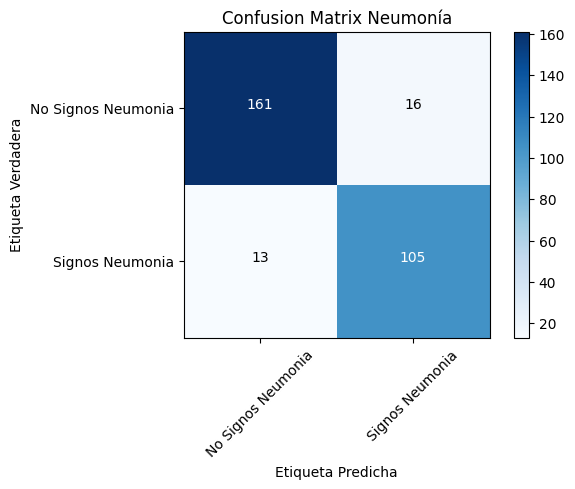

In [59]:
plot_confusion_matrix(cm = cm_train, classes = etiquetas_vf,title = "Confusion Matrix Neumonía")

Confusion matrix without normalization


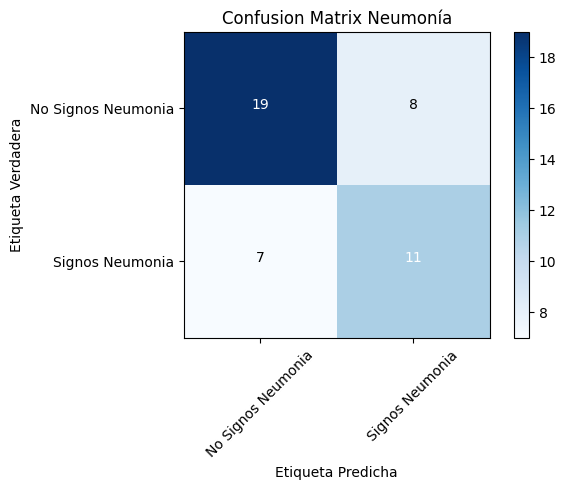

In [60]:
plot_confusion_matrix(cm = cm_valid, classes = etiquetas_vf,title = "Confusion Matrix Neumonía")

Confusion matrix without normalization


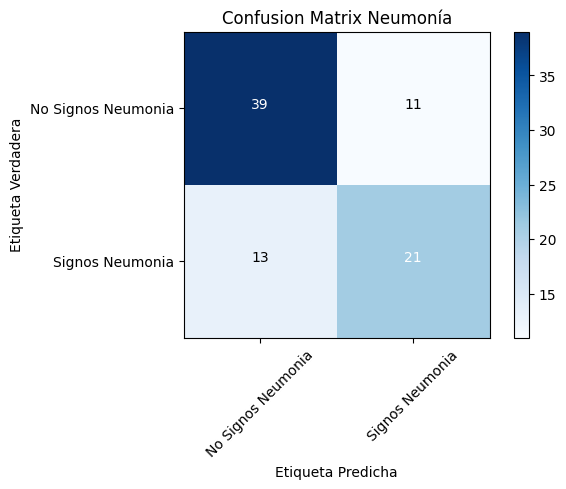

In [61]:
plot_confusion_matrix(cm = cm_test, classes = etiquetas_vf,title = "Confusion Matrix Neumonía")

In [62]:
valid_df['Label'].value_counts()

Label
0    27
1    18
Name: count, dtype: int64